### Data visualization

In [2]:
path = 'C:/Users/Haiya/Downloads/arrest and controls with all t3 data/'
file = path + 'study ID 7C2 t3 all.csv'

### Read and Visualize SO2-2 and SO2-1

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pycwt import wavelet

In [34]:
def filter_large_slopes(df, time_col, value_cols, threshold=4000):
    df = df.copy()
    t = df[time_col].values

    for col in value_cols:
        y = df[col].values
        slopes = np.abs(np.diff(y) / np.diff(t))
        mask = np.insert(slopes >= threshold, 0, False)  # Align length
        y[mask] = np.nan
        df[col] = y

    return df

In [36]:
def convert_time_to_minutes_pure(df, time_col):
    """
    Convert 'MM/DD/YYYY HH:MM' in 24-hour format to minutes from first valid time.
    Ignores year, handles missing values as None.
    """
    times = []

    for s in df[time_col]:
        if not s or not isinstance(s, str):
            times.append(None)
            continue

        parts = s.strip().split()
        if len(parts) != 2:
            times.append(None)
            continue

        date_part = parts[0]
        time_part = parts[1]

        try:
            month, day, _ = [int(x) for x in date_part.split('/')]
            hour, minute = [int(x) for x in time_part.split(':')]
        except ValueError:
            times.append(None)
            continue

        total_minutes = (day * 24 * 60) + (hour * 60) + minute
        times.append(total_minutes)

    # Shift so first valid time starts at 0
    valid_times = [t for t in times if t is not None]
    if valid_times:
        start = valid_times[0]
        times = [(t - start) if t is not None else None for t in times]

    df[time_col] = times
    return df


### factors

In [39]:
factor1 = 'ARTd (mmHg)'
factor2 = 'rSO2-1 (%)'

In [56]:
df_all = pd.read_csv(file, dtype=str)
col_idx1 = df_all.columns.get_loc(factor1)
col_idx2 = df_all.columns.get_loc(factor2)
df = df_all.iloc[:, [0, col_idx1, col_idx2]]
df.columns = ['Time', factor1, factor2]
df[factor1] = pd.to_numeric(df[factor1], errors='coerce')
df[factor2] = pd.to_numeric(df[factor2], errors='coerce')
df_fixed = convert_time_to_minutes_pure(df, time_col='Time')
df_fixed['Time'] = df_fixed['Time'] - df_fixed['Time'].min()
df_filtered = filter_large_slopes(df_fixed, time_col='Time',
                                   value_cols=[factor1, factor2],
                                   threshold=1000)
print(np.max(df_fixed['Time']), np.min(df_fixed['Time']))
df_fixed['Time'] = np.clip(df_fixed['Time'], 0, 5000)
#print(df_filtered.head(20))
#print(max(df_filtered[factor1]))
#print(max(df[factor1]))

7231 0


C:\Users\Haiya\AppData\Local\Temp\ipykernel_24468\671172550.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[factor1] = pd.to_numeric(df[factor1], errors='coerce')
C:\Users\Haiya\AppData\Local\Temp\ipykernel_24468\671172550.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[factor2] = pd.to_numeric(df[factor2], errors='coerce')
C:\Users\Haiya\AppData\Local\Temp\ipykernel_24468\4279385025.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

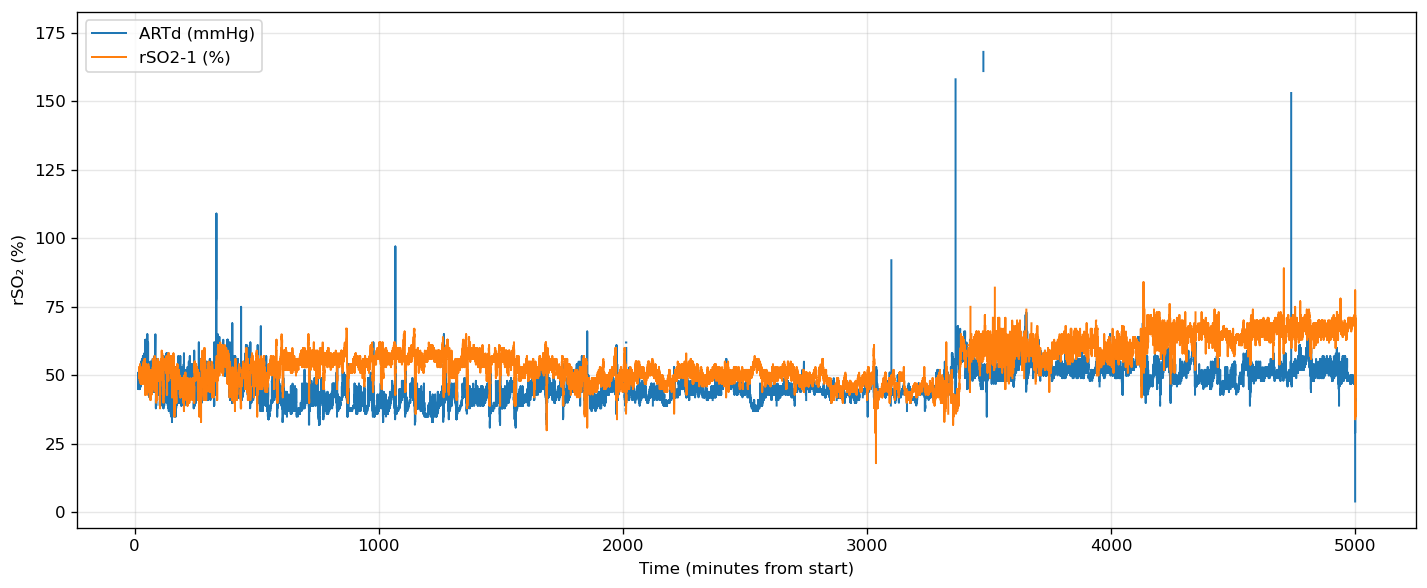

In [57]:
x = df['Time']
xlabel = 'Time (minutes from start)'
plt.figure(figsize=(12, 5), dpi=120) 
plt.plot(x, df[factor1], label=factor1, lw=1.2)
plt.plot(x, df[factor2], label=factor2, lw=1.2)
plt.xlabel(xlabel)
plt.ylabel('rSO₂ (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

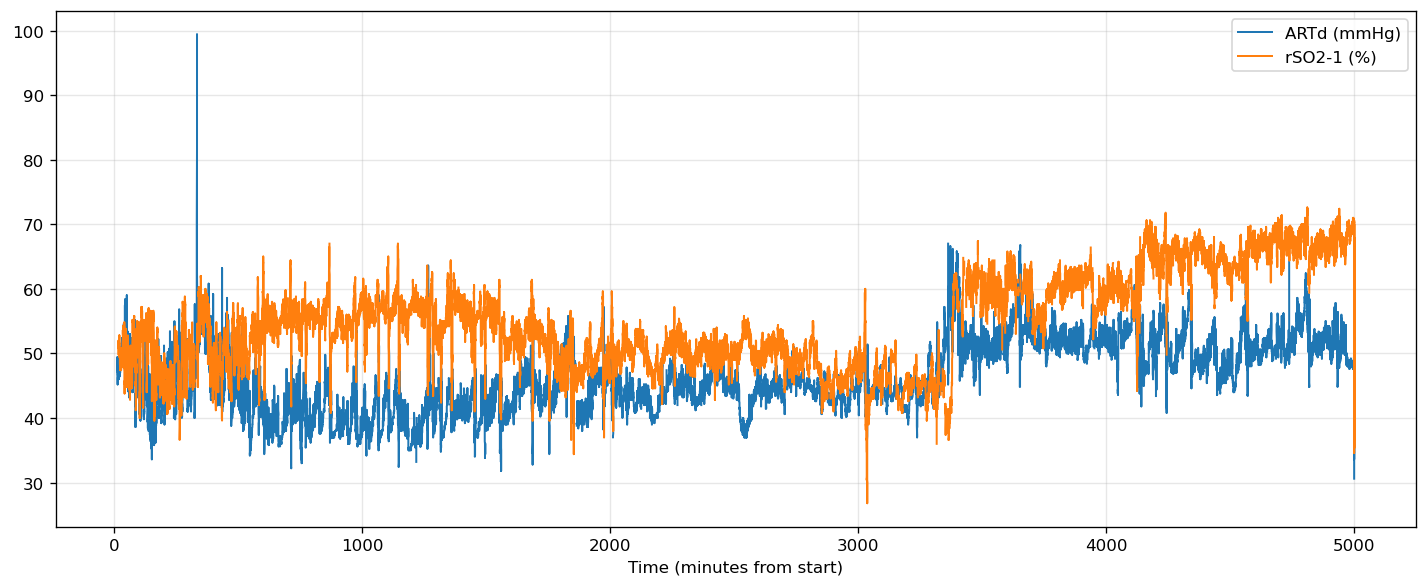

In [60]:
# moving average filter
def moving_average(a, window_size=5):
    kernel = np.ones(window_size) / window_size
    return np.convolve(a, kernel, mode='same')

x = df['Time']
xlabel = 'Time (minutes from start)'

# smooth signals
rso2_2_smooth = moving_average(df[factor1].to_numpy(), window_size=5)
rso2_1_smooth = moving_average(df[factor2].to_numpy(), window_size=5)

plt.figure(figsize=(12, 5), dpi=120)
plt.plot(x, rso2_2_smooth, label=factor1, lw=1.2)
plt.plot(x, rso2_1_smooth, label=factor2, lw=1.2)
plt.xlabel(xlabel)
#plt.ylabel('rSO₂ (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

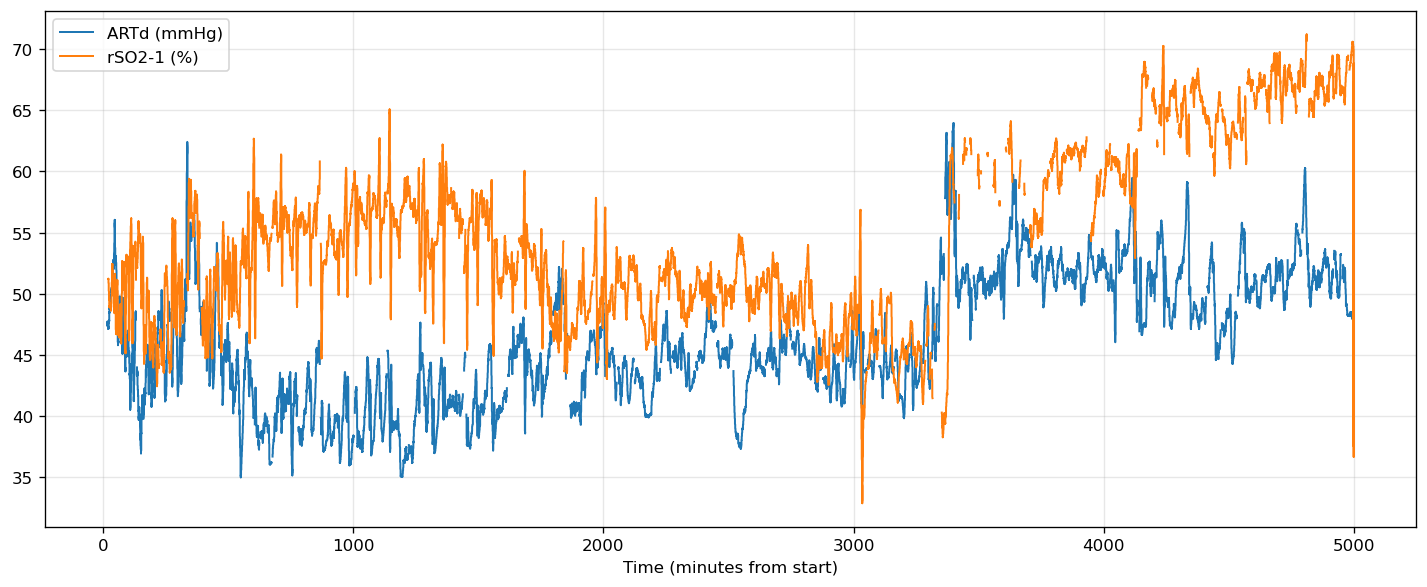

In [62]:
x = df['Time']
xlabel = 'Time (minutes from start)'

# smooth signals
rso2_2_smooth = moving_average(df[factor1].to_numpy(), window_size=50)
rso2_1_smooth = moving_average(df[factor2].to_numpy(), window_size=50)

plt.figure(figsize=(12, 5), dpi=120)
plt.plot(x, rso2_2_smooth, label=factor1, lw=1.2)
plt.plot(x, rso2_1_smooth, label=factor2, lw=1.2)
plt.xlabel(xlabel)
#plt.ylabel('rSO₂ (%)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


### WTC maps

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from pycwt import wavelet

# ---------- pull data from your df_filtered ----------
t_raw = df_filtered['Time'].to_numpy(float)            # minutes from start
x_raw = df_filtered[factor1].to_numpy(float)
y_raw = df_filtered[factor2].to_numpy(float)

# ---------- helpers ----------
def interp_uniform_safe(t, s, max_points=10000):
    """Uniform grid with bounded size; removes NaNs & duplicate timestamps."""
    m = np.isfinite(t) & np.isfinite(s)
    t = np.asarray(t[m], float); s = np.asarray(s[m], float)
    if t.size < 2:
        raise ValueError("Not enough points after filtering.")
    order = np.argsort(t); t = t[order]; s = s[order]
    # collapse exact duplicate times
    dt = np.diff(t); keep = np.hstack(([True], dt != 0))
    t_u = t[keep]; s_u = s[keep]
    n_target = min(max_points, max(2, t_u.size))
    t_uni = np.linspace(t_u[0], t_u[-1], n_target)
    s_uni = np.interp(t_uni, t_u, s_u)
    eff_dt = (t_uni[-1] - t_uni[0]) / (n_target - 1)
    return t_uni, s_uni, float(eff_dt)

def cwt_wrap(sig, dt, dj, s0, J, wv='morlet'):
    """Return (W, scales, coi) across pycwt variants."""
    out = wavelet.cwt(sig, dt, dj=dj, s0=s0, J=J, wavelet=wv)
    W, scales = out[0], out[1]
    coi = out[3] if len(out) >= 4 else None
    return W, np.asarray(scales, float), (None if coi is None else np.asarray(coi, float))

def centers_to_edges(c):
    c = np.asarray(c, float).ravel()
    if c.size < 2: return np.array([c[0]-0.5, c[0]+0.5], float)
    dc = np.diff(c); e = np.empty(c.size + 1, float)
    e[1:-1] = c[:-1] + dc/2; e[0] = c[0] - dc[0]/2; e[-1] = c[-1] + dc[-1]/2
    return e

def _smooth_time_scale(A, scales, dt, dj):
    """Gaussian time smoothing (σ≈√2·scale/dt) + boxcar scale smoothing (~1/dj)."""
    A = np.asarray(A); Ns, Nt = A.shape
    out = np.empty((Ns, Nt), dtype=np.complex128)
    scales = np.asarray(scales, float).ravel()
    for i, s in enumerate(scales):
        sigma_t = max(1e-9, np.sqrt(2.0) * (s / dt))         # samples
        L = int(np.ceil(6.0 * sigma_t))
        if 2*L + 1 > Nt: L = max(1, (Nt - 1) // 2)           # cap kernel
        if L < 1: 
            out[i, :] = A[i, :]; 
            continue
        kx = np.arange(-L, L + 1, dtype=float)
        g = np.exp(-(kx**2) / (2.0 * sigma_t**2)); g /= g.sum()
        conv = np.convolve(A[i, :], g, mode='same')
        out[i, :] = conv[:Nt]
    # boxcar over scales
    w = max(1, int(round(1.0 / dj)))
    if w > 1:
        box = np.ones(w, dtype=float) / w
        for tcol in range(Nt):
            out[:, tcol] = np.convolve(out[:, tcol], box, mode='same')[:Ns]
    return out

def wtc_from_cwt(Wx, Wy, scales, dt, dj, eps=1e-12):
    """Magnitude-squared wavelet coherence from two CWTs (Grinsted/Torrence)."""
    scales = np.asarray(scales, float).ravel()
    s_inv = (1.0 / scales)[:, None]
    Wxy = Wx * np.conj(Wy)
    Sxy = _smooth_time_scale(Wxy * s_inv, scales, dt, dj)
    Sxx = _smooth_time_scale((np.abs(Wx)**2) * s_inv, scales, dt, dj)
    Syy = _smooth_time_scale((np.abs(Wy)**2) * s_inv, scales, dt, dj)
    WCT = (np.abs(Sxy)**2) / (Sxx * Syy + eps)
    return np.clip(WCT.real, 0.0, 1.0)

def coi_to_period(coi, scales, dt, fourier_factor):
    """If COI is in scales, convert to period; otherwise assume already period."""
    coi = np.asarray(coi, float).ravel()
    scales = np.asarray(scales, float).ravel()
    if np.nanmax(coi) <= np.nanmax(scales) * 1.05:
        return fourier_factor * coi * dt
    return coi

def match_len(x_ref, y):
    y = np.asarray(y, float).ravel(); x_ref = np.asarray(x_ref, float).ravel()
    if y.size == x_ref.size: return y
    idx = np.linspace(0, y.size - 1, x_ref.size)
    return np.interp(idx, np.arange(y.size), y)

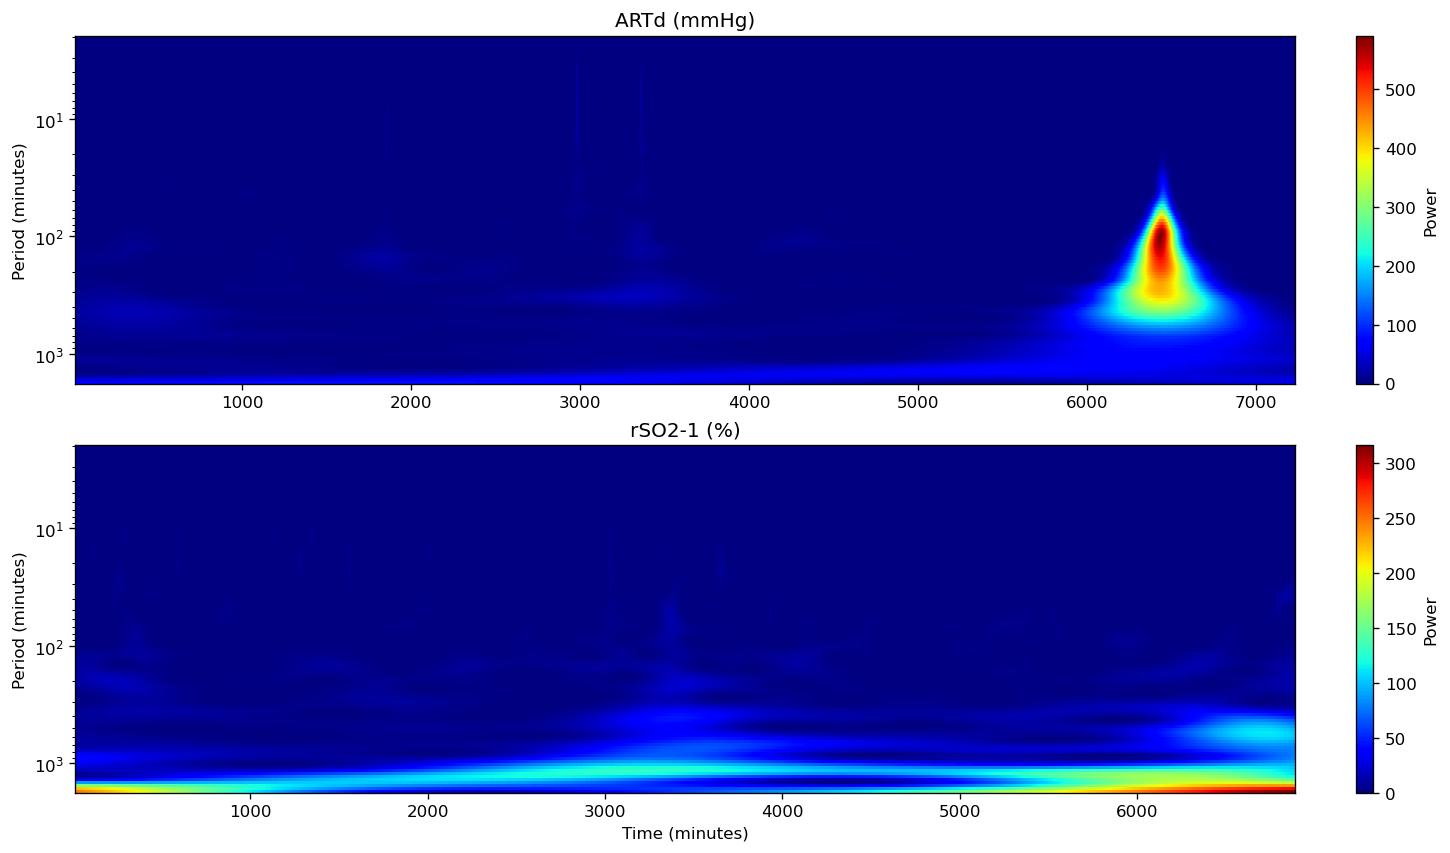

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from pycwt import wavelet

# -------------------
# Config (edit factors here)
# -------------------
# factor1 = 'NBPm (mmHg)'
# factor2 = 'rSO2-1 (%)'

# -------------------
# Pull data (Time already in minutes)
# -------------------
t_raw = df_filtered['Time'].to_numpy(float)
x_raw = df_filtered[factor1].to_numpy(float)
y_raw = df_filtered[factor2].to_numpy(float)

# -------------------
# Helpers
# -------------------
def interp_uniform_safe(t, s, max_points=10000):
    """Uniform grid with bounded size; removes NaNs & duplicate timestamps."""
    m = np.isfinite(t) & np.isfinite(s)
    t = np.asarray(t[m], float)
    s = np.asarray(s[m], float)
    if t.size < 2:
        raise ValueError("Not enough points after filtering.")
    order = np.argsort(t)
    t = t[order]; s = s[order]

    # collapse exact duplicate times
    dt = np.diff(t)
    keep = np.hstack(([True], dt != 0))
    t_u = t[keep]; s_u = s[keep]

    n_target = min(max_points, max(2, t_u.size))
    t_uni = np.linspace(t_u[0], t_u[-1], n_target)
    s_uni = np.interp(t_uni, t_u, s_u)
    eff_dt = (t_uni[-1] - t_uni[0]) / (n_target - 1)
    return t_uni, s_uni, float(eff_dt)

def centers_to_edges(c):
    """Convert center coords -> edges of length len(c)+1 (for shading='flat')."""
    c = np.asarray(c, float).ravel()
    if c.size < 2:
        return np.array([c[0]-0.5, c[0]+0.5], float)
    dc = np.diff(c)
    e = np.empty(c.size + 1, float)
    e[1:-1] = c[:-1] + dc/2
    e[0]    = c[0]  - dc[0]/2
    e[-1]   = c[-1] + dc[-1]/2
    return e

def cwt_wrap(sig, dt, dj, s0, J, wv='morlet'):
    """Return (W, scales, coi) across pycwt variants."""
    out = wavelet.cwt(sig, dt, dj=dj, s0=s0, J=J, wavelet=wv)
    W, scales = out[0], out[1]
    coi = out[3] if len(out) >= 4 else None
    return W, np.asarray(scales, float), (None if coi is None else np.asarray(coi, float))

# -------------------
# Uniformize both signals on the same grid
# -------------------
t, x, dt = interp_uniform_safe(t_raw, x_raw, max_points=10000)
_, y, _  = interp_uniform_safe(t_raw, y_raw, max_points=len(t))

# Z-score each
def zscore(a):
    a = np.asarray(a, float)
    mu, sd = a.mean(), a.std()
    return (a - mu) / (sd if sd else 1.0)

x = zscore(x)
y = zscore(y)

# -------------------
# Scale ladder (time unit = minutes)
# -------------------
VOICES = 12
dj = 1.0 / VOICES
W0 = 6.0
FOURIER_FACTOR = 4*np.pi / (W0 + np.sqrt(2 + W0**2))  # ~1.033

period_min = 2.0 * dt
period_max = (t[-1] - t[0]) / 4.0
s0   = period_min / (FOURIER_FACTOR * dt)
smax = period_max / (FOURIER_FACTOR * dt)
J    = int(np.floor(np.log2(smax / s0) / dj))

# -------------------
# CWTs
# -------------------
Wx, scales, _  = cwt_wrap(x, dt, dj, s0, J, wv='morlet')
Wy, scales2, _ = cwt_wrap(y, dt, dj, s0, J, wv='morlet')
# (scales2 should match scales)
periods = FOURIER_FACTOR * scales * dt  # minutes

Px = np.abs(Wx)**2
Py = np.abs(Wy)**2

# -------------------
# Plot scalograms with correct edges
# -------------------
Ns_x, Nt_x = Px.shape
Ns_y, Nt_y = Py.shape

# Build edges that match each C's shape
t_edges_x = centers_to_edges(t[:Nt_x])         # length Nt_x + 1
p_edges_x = centers_to_edges(periods[:Ns_x])   # length Ns_x + 1

t_edges_y = centers_to_edges(t[:Nt_y])         # length Nt_y + 1
p_edges_y = centers_to_edges(periods[:Ns_y])   # length Ns_y + 1

fig, axes = plt.subplots(2, 1, figsize=(12, 7), dpi=120, constrained_layout=True)

# Top: factor1
ax = axes[0]
im = ax.pcolormesh(t_edges_x, p_edges_x, Px, cmap='jet', shading='flat')
ax.set_title(factor1)
ax.set_ylabel('Period (minutes)')
ax.set_yscale('log'); ax.invert_yaxis()
fig.colorbar(im, ax=ax, label='Power')

# Bottom: factor2
ax = axes[1]
im = ax.pcolormesh(t_edges_y, p_edges_y, Py, cmap='jet', shading='flat')
ax.set_title(factor2)
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Period (minutes)')
ax.set_yscale('log'); ax.invert_yaxis()
fig.colorbar(im, ax=ax, label='Power')

plt.show()


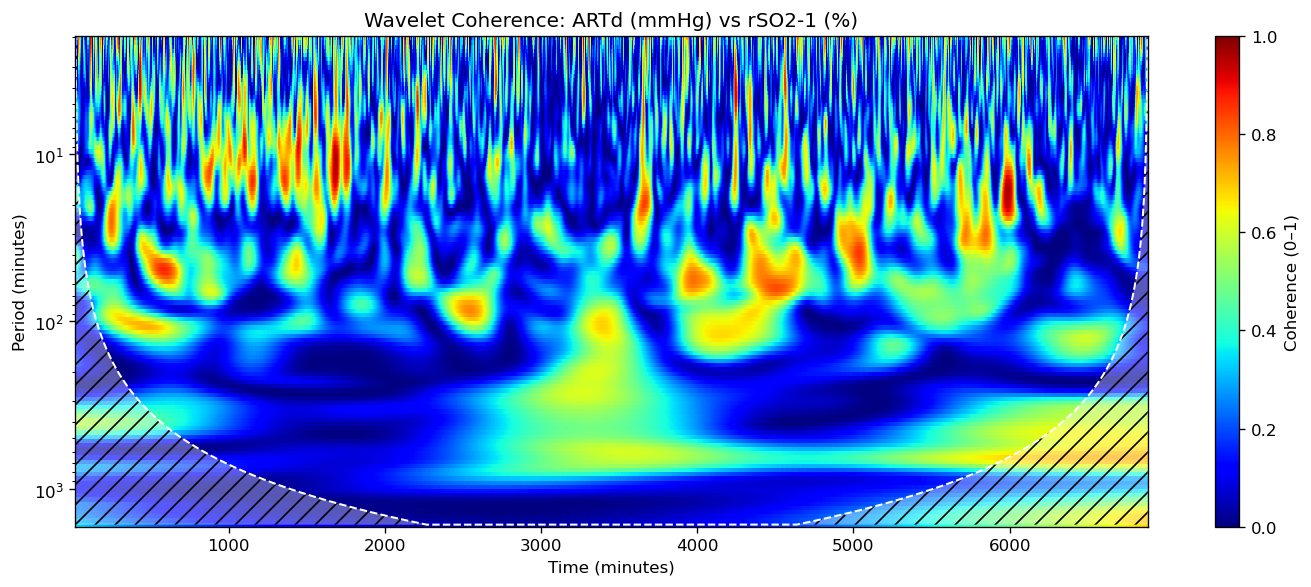

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from pycwt import wavelet

# =========================
# Helpers
# =========================
def _prep_unique_sorted(t, s):
    """Keep finite, sort by time, collapse duplicate timestamps."""
    m = np.isfinite(t) & np.isfinite(s)
    t = np.asarray(t[m], float)
    s = np.asarray(s[m], float)
    if t.size < 2:
        raise ValueError("Not enough points after filtering.")
    order = np.argsort(t)
    t = t[order]; s = s[order]
    dt = np.diff(t)
    keep = np.hstack(([True], dt != 0))
    return t[keep], s[keep]

def centers_to_edges(c):
    """Convert centers -> edges (len+1) for pcolormesh(shading='flat')."""
    c = np.asarray(c, float).ravel()
    if c.size < 2:
        return np.array([c[0]-0.5, c[0]+0.5], float)
    dc = np.diff(c)
    e = np.empty(c.size + 1, float)
    e[1:-1] = c[:-1] + dc/2
    e[0]    = c[0]  - dc[0]/2
    e[-1]   = c[-1] + dc[-1]/2
    return e

def cwt_wrap(sig, dt, dj, s0, J, wv='morlet'):
    """Return (W, scales, coi) robustly across pycwt variants."""
    out = wavelet.cwt(sig, dt, dj=dj, s0=s0, J=J, wavelet=wv)
    W, scales = out[0], out[1]
    coi = out[3] if len(out) >= 4 else None
    return W, np.asarray(scales, float), (None if coi is None else np.asarray(coi, float))

def _smooth_time_scale(A, scales, dt, dj):
    """Gaussian time smoothing (σ≈√2·scale/dt) + boxcar across scales (~1/dj)."""
    A = np.asarray(A)
    Ns, Nt = A.shape
    out = np.empty((Ns, Nt), dtype=np.complex128)
    scales = np.asarray(scales, float).ravel()
    for i, s in enumerate(scales):
        sigma_t = max(1e-9, np.sqrt(2.0) * (s / dt))   # in samples
        L = int(np.ceil(6.0 * sigma_t))                # ~±3σ
        if 2*L + 1 > Nt:
            L = max(1, (Nt - 1) // 2)
        if L < 1:
            out[i, :] = A[i, :]
            continue
        kx = np.arange(-L, L + 1, dtype=float)
        g = np.exp(-(kx**2) / (2.0 * sigma_t**2)); g /= g.sum()
        conv = np.convolve(A[i, :], g, mode='same')
        out[i, :] = conv[:Nt]
    # scale smoothing
    w = max(1, int(round(1.0 / dj)))
    if w > 1:
        box = np.ones(w, dtype=float) / w
        for tcol in range(Nt):
            out[:, tcol] = np.convolve(out[:, tcol], box, mode='same')[:Ns]
    return out

def wtc_from_cwt(Wx, Wy, scales, dt, dj, eps=1e-12):
    """Grinsted/Torrence WTC from CWTs."""
    scales = np.asarray(scales, float).ravel()
    s_inv = (1.0 / scales)[:, None]
    Wxy = Wx * np.conj(Wy)
    Sxy = _smooth_time_scale(Wxy * s_inv, scales, dt, dj)
    Sxx = _smooth_time_scale((np.abs(Wx)**2) * s_inv, scales, dt, dj)
    Syy = _smooth_time_scale((np.abs(Wy)**2) * s_inv, scales, dt, dj)
    WCT = (np.abs(Sxy)**2) / (Sxx * Syy + eps)
    return np.clip(WCT.real, 0.0, 1.0)

def coi_to_period(coi, scales, dt, fourier_factor):
    """If COI looks like scales, convert to period; else assume already period."""
    coi = np.asarray(coi, float).ravel()
    scales = np.asarray(scales, float).ravel()
    if np.nanmax(coi) <= np.nanmax(scales) * 1.05:
        return fourier_factor * coi * dt
    return coi

def match_len(x_ref, y):
    y = np.asarray(y, float).ravel(); x_ref = np.asarray(x_ref, float).ravel()
    if y.size == x_ref.size: return y
    idx = np.linspace(0, y.size - 1, x_ref.size)
    return np.interp(idx, np.arange(y.size), y)

# =========================
# Data (assumes df_filtered, factor1, factor2 exist; Time in minutes)
# =========================
t_raw = df_filtered['Time'].to_numpy(float)
x_raw = df_filtered[factor1].to_numpy(float)
y_raw = df_filtered[factor2].to_numpy(float)

# =========================
# Shared uniform grid (fixes Wx/Wy mismatch)
# =========================
tx_u, x_u = _prep_unique_sorted(t_raw, x_raw)
ty_u, y_u = _prep_unique_sorted(t_raw, y_raw)

t0 = max(tx_u[0], ty_u[0])
t1 = min(tx_u[-1], ty_u[-1])
if not (t1 > t0):
    raise ValueError("No overlapping time interval between the two signals.")

n_target = int(min(10000, tx_u.size, ty_u.size))
n_target = max(n_target, 1024)
t = np.linspace(t0, t1, n_target).astype(float)
dt = float((t[-1] - t[0]) / (n_target - 1))

x = np.interp(t, tx_u, x_u)
y = np.interp(t, ty_u, y_u)

# z-score (recommended)
def z(a):
    a = np.asarray(a, float)
    mu, sd = a.mean(), a.std()
    return (a - mu) / (sd if sd else 1.0)

x = z(x); y = z(y)

# =========================
# Scale ladder (minutes)
# =========================
VOICES = 12
dj = 1.0 / VOICES
W0 = 6.0
FOURIER_FACTOR = 4*np.pi / (W0 + np.sqrt(2 + W0**2))  # ~1.033

period_min = 2.0 * dt
period_max = (t[-1] - t[0]) / 4.0
s0   = period_min / (FOURIER_FACTOR * dt)
smax = period_max / (FOURIER_FACTOR * dt)
J    = int(np.floor(np.log2(smax / s0) / dj))

# =========================
# CWTs
# =========================
Wx, scales, coi_x = cwt_wrap(x, dt, dj, s0, J, wv='morlet')
Wy, scales2, coi_y = cwt_wrap(y, dt, dj, s0, J, wv='morlet')  # should match 'scales'
periods = FOURIER_FACTOR * scales * dt  # minutes

# =========================
# WTC (from CWTs)
# =========================
WCT = wtc_from_cwt(Wx, Wy, scales, dt, dj)

# COI for WTC: conservative min, in period units, matched to t
coi_period = None
if coi_x is not None and coi_y is not None:
    coi_min = np.minimum(coi_x, coi_y)
    coi_period = coi_to_period(coi_min, scales, dt, FOURIER_FACTOR)
    coi_period = match_len(t, coi_period)
    coi_period = np.clip(coi_period, periods.min(), periods.max())

# =========================
# Plot WTC + COI
# =========================
t_edges = centers_to_edges(t)
p_edges = centers_to_edges(periods)

fig, ax = plt.subplots(figsize=(12, 5), dpi=120)
im = ax.pcolormesh(t_edges, p_edges, WCT, cmap='jet', shading='flat', vmin=0, vmax=1)
ax.set_title(f'Wavelet Coherence: {factor1} vs {factor2}')
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Period (minutes)')
ax.set_yscale('log'); ax.invert_yaxis()
fig.colorbar(im, ax=ax, label='Coherence (0–1)')

if coi_period is not None:
    ax.plot(t, coi_period, 'w--', lw=1.2)
    ax.fill_between(
        t, coi_period, periods.max(),
        where=coi_period <= periods.max(),
        facecolor='white', alpha=0.35, hatch='//', edgecolor='none'
    )

plt.tight_layout()
plt.show()


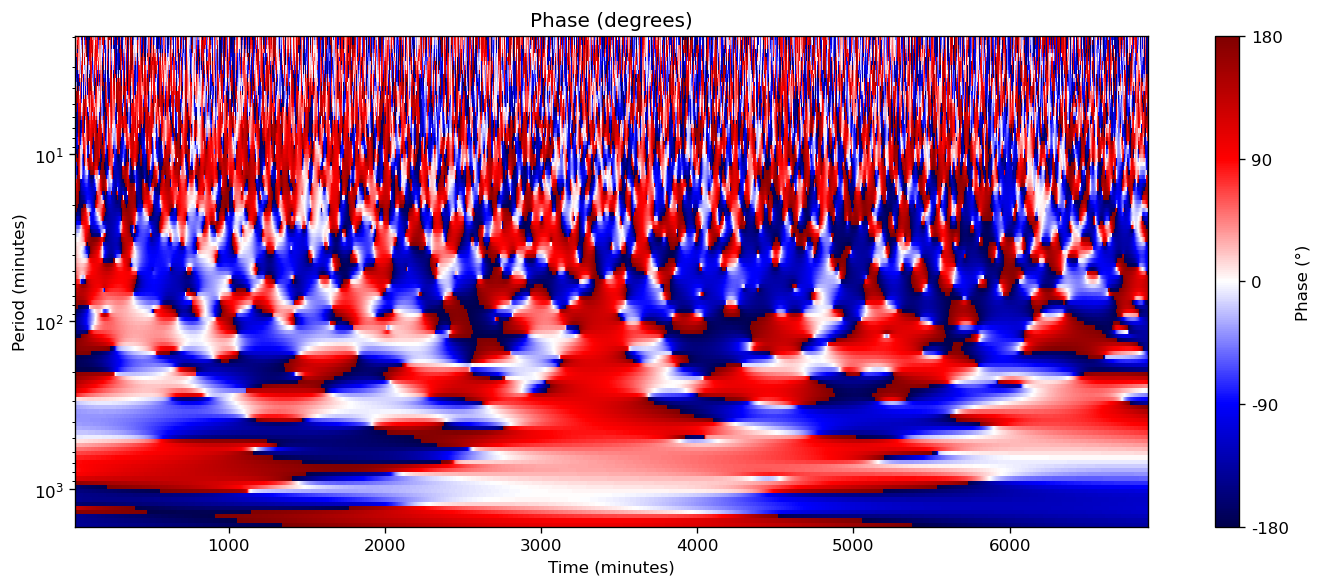

In [80]:
# --- Compute phase from cross-spectrum Sxy ---
Sxy = Wx * np.conj(Wy)  # cross-wavelet transform
phase = np.angle(Sxy)   # range: -pi to pi

# --- Plot phase map ---
fig, ax = plt.subplots(figsize=(12, 5), dpi=120)
im = ax.pcolormesh(
    t_edges, p_edges, phase,
    cmap='seismic', shading='flat', vmin=-np.pi, vmax=np.pi
)
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Period (minutes)')
ax.set_title('Phase (degrees)')
ax.set_yscale('log')
ax.invert_yaxis()

# colorbar in degrees
cbar = fig.colorbar(im, ax=ax, label='Phase (°)')
cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.set_ticklabels(['-180', '-90', '0', '90', '180'])

plt.tight_layout()
plt.show()

In [82]:
THRESH = 0.65  # coherence cutoff

# Build a mask: True = exclude
mask = np.zeros_like(WCT, dtype=bool)

# 1) Exclude outside COI (periods greater than the COI curve)
if coi_period is not None:
    # periods is (Ns,), t is (Nt,)
    outside_cone = (periods[:, None] > coi_period[None, :])
    mask |= outside_cone

# 2) Exclude low coherence
mask |= (WCT < THRESH)

# Apply mask (set excluded cells to NaN so pcolormesh leaves them blank)
WCT_masked = np.where(mask, np.nan, WCT)

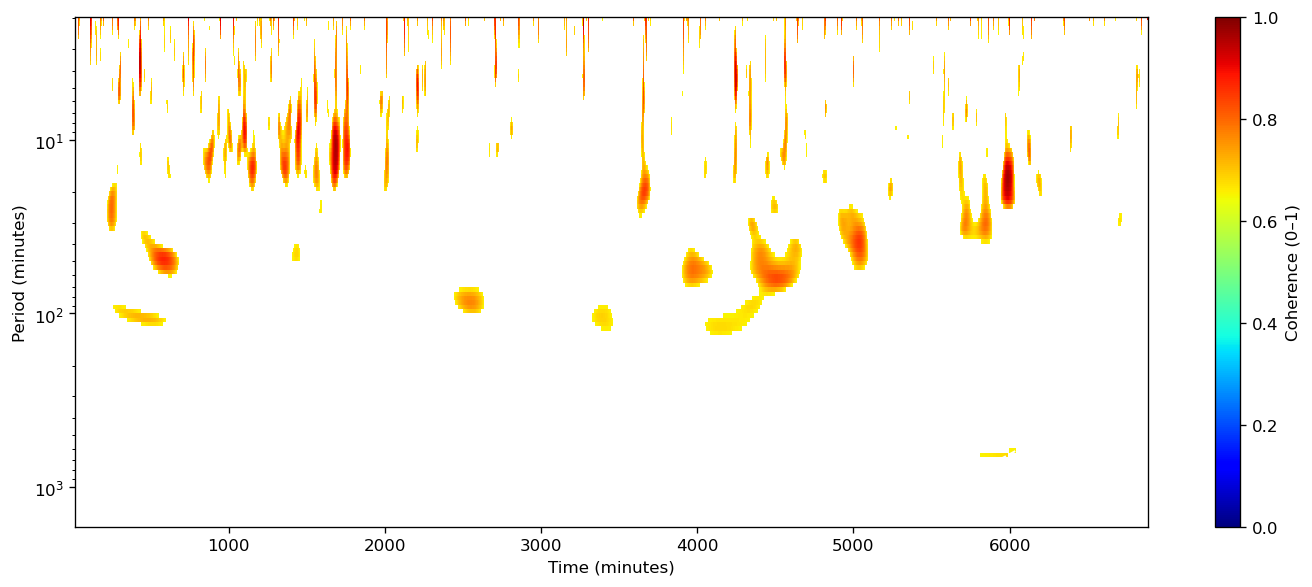

In [83]:
t_edges = centers_to_edges(t)
p_edges = centers_to_edges(periods)

fig, ax = plt.subplots(figsize=(12, 5), dpi=120)
im = ax.pcolormesh(t_edges, p_edges, WCT_masked, cmap='jet',
                   shading='flat', vmin=0, vmax=1)
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Period (minutes)')
ax.set_yscale('log'); ax.invert_yaxis()
cbar = fig.colorbar(im, ax=ax, label='Coherence (0–1)')

# Draw COI line and lightly shade outside (optional cosmetic)
if coi_period is not None:
    ax.plot(t, coi_period, 'w--', lw=1.2)
    #ax.fill_between(t, coi_period, periods.max(),
    #                where=coi_period <= periods.max(),
    #                facecolor='white', alpha=0.25, hatch='//', edgecolor='none')
plt.tight_layout()
plt.show()

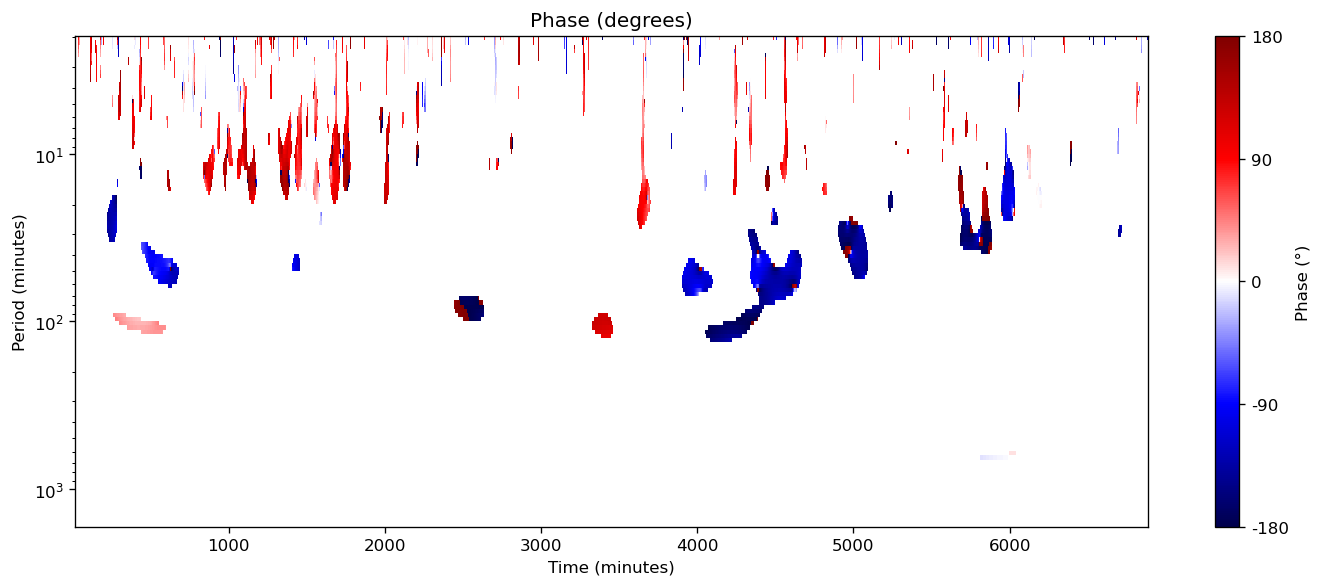

In [84]:
# Apply the same mask to phase
phase_masked = np.where(np.isnan(WCT_masked), np.nan, phase)

# --- Plot masked phase map ---
fig, ax = plt.subplots(figsize=(12, 5), dpi=120)
im = ax.pcolormesh(
    t_edges, p_edges, phase_masked,
    cmap='seismic', shading='flat', vmin=-np.pi, vmax=np.pi
)
ax.set_xlabel('Time (minutes)')
ax.set_ylabel('Period (minutes)')
ax.set_title('Phase (degrees)')
ax.set_yscale('log')
ax.invert_yaxis()

# Colorbar in degrees
cbar = fig.colorbar(im, ax=ax, label='Phase (°)')
cbar.set_ticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
cbar.set_ticklabels(['-180', '-90', '0', '90', '180'])
plt.tight_layout()
plt.show()